# Report 04
### Daniel Bishop

License: Attribution 4.0 International (CC BY 4.0) 

In [94]:
from thinkbayes2 import Pmf, Suite, Joint
from itertools import product
import thinkplot
import numpy as np
% matplotlib inline

ImportError: cannot import name 'EvalWeibullPdf'

## Extended Paintball
#### Chapter 9
In our simple model, the opponent is equally likely to shoot in any direction. As an exercise, let’s consider improvements to this model.
The analysis in this chapter suggests that a shooter is most likely to hit the closest wall. But in reality, if the opponent is close to a wall, he is unlikely to shoot at the wall because he is unlikely to see a target between himself and the wall.  

Design an improved model that takes this behavior into account. Try to find a model that is more realistic, but not too complicated.

First we use the original implementation form chapter 9:

In [8]:
class Paintball(Suite, Joint):
    """Represents hypotheses about the location of an opponent."""

    def __init__(self, alphas, betas, locations):
        """Makes a joint suite of parameters alpha and beta.

        Enumerates all pairs of alpha and beta.
        Stores locations for use in Likelihood.

        alphas: possible values for alpha
        betas: possible values for beta
        locations: possible locations along the wall
        """
        self.locations = locations
        pairs = [(alpha, beta) 
                 for alpha in alphas 
                 for beta in betas]
        Suite.__init__(self, pairs)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: pair of alpha, beta
        data: location of a hit

        Returns: float likelihood
        """
        alpha, beta = hypo
        x = data
        pmf = MakeLocationPmf(alpha, beta, self.locations)
        like = pmf.Prob(x)
        return like

However, we make a slight modification to the algorithms used by the Likelihood function to make shooting near walls less probable.

In [60]:
import math

def MakeLocationPmf(alpha, beta, locations):
    """Computes the Pmf of the locations, given alpha and beta. 

    Given that the shooter is at coordinates (alpha, beta),
    the probability of hitting any spot is inversely proportionate
    to the strafe speed.

    alpha: x position
    beta: y position
    locations: x locations where the pmf is evaluated

    Returns: Pmf object
    """
    pmf = Pmf()
    for x in locations:
        dist = math.sqrt((alpha - x)**2 + (beta**2))
        prob = (1.0 / StrafingSpeed(alpha, beta, x)) * dist
        pmf.Set(x, prob)
    pmf.Normalize()
    return pmf

def StrafingSpeed(alpha, beta, x):
    """Computes strafing speed, given location of shooter and impact.

    alpha: x location of shooter
    beta: y location of shooter
    x: location of impact

    Returns: derivative of x with respect to theta
    """
    theta = math.atan2(x - alpha, beta)
    speed = beta / math.cos(theta)**2
    return speed

In [62]:
alphas = range(0, 31)
betas = range(1, 51)
locations = range(0, 31)

suite = Paintball(alphas, betas, locations)
suite.UpdateSet([15, 16, 18, 21])

1.441072655985377e-06

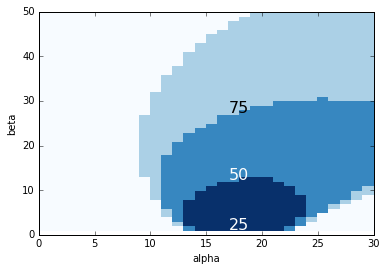

In [63]:
d = dict((pair, 0) for pair in suite.Values())

percentages = [75, 50, 25]
for p in percentages:
    interval = suite.MaxLikeInterval(p)
    for pair in interval:
        d[pair] += 1

thinkplot.Contour(d, contour=False, pcolor=True)
thinkplot.Text(17, 4, '25', color='white')
thinkplot.Text(17, 15, '50', color='white')
thinkplot.Text(17, 30, '75')

thinkplot.Config(xlabel='alpha',
                   ylabel='beta',
                   legend=False)

Here we see that adding the parameter that the shooter is less likely to shoot a wall close to him has made us more uncertain of where the shooter actually is. since there is a higher chance than before of him being near the wall and instead shooting a far away wall, the area that a potential shooter could be in grows.

## Best of 30 

Suppose that in a game where two teams compete against each other for 30 rounds, the first team to win 16 rounds wins the match. In the event of a tie, they go to an overtime best of 6 rounds. If one team sweeps all of its placement matches with scores of 16-2, 16-1, and 16-4, while another team only narrowly wins its matches with scores of 16-13, 19-17, and 16-14, what is the likelihood of team A beating team B?

If we assume that each round has no impact on the round following it, we can model the # of rounds won by each team as a Poisson distribution.

In [71]:
from thinkbayes2 import EvalPoissonPmf, MakePoissonPmf

teamA = MakePoissonPmf(16, 30)
teamB = MakePoissonPmf(15.667, 30)

Note that team B has a slightly lower average rounds per game as they tied one game and went to overtime.

Taking both pmf's, we can compute the probability of one team winning 16 rounds while the other wins <15.

In [76]:
prob_A_win = 0
prob_B_win = 0

for i in range(15):
    prob_A_win += EvalPoissonPmf(16, 16) * EvalPoissonPmf(i, 15.667)
    prob_B_win += EvalPoissonPmf(16, 15.667) * EvalPoissonPmf(i, 16)
    
print(prob_A_win)
print(prob_B_win)

0.0395999906143
0.0363372392009


Here we can see that team A has a slightly higher chance of winning due to their higher average rounds per game not counting overtime.

In [77]:
prob_tie = EvalPoissonPmf(15, 16) * EvalPoissonPmf(15, 15.667)
print(prob_tie)

0.0100180872685


However, there is a chance that they will tie, in which case they will play a match of 6 rounds.

In [78]:
for i in range(3):
    prob_A_win += prob_tie * EvalPoissonPmf(4, 16 * 6/30) * EvalPoissonPmf(i, 15.667 * 6/30)
    prob_B_win += prob_tie * EvalPoissonPmf(4, 15.667 * 6/30) * EvalPoissonPmf(i, 16 * 6/30)
    
print(prob_A_win)
print(prob_B_win)

0.0403029030411
0.0370032667077


In overtime, team A's advantage grows as their superior average scoring helps them gain more overtime rounds.

## Survival of parts
Suppose you sell respirators to people, and have a built in feature that reports back to you when the respirator breaks. Instead of testing the gear yourself, you decide to sell it to a bunch of people and observe the lifespan of the part, then offer a warranty program that expires just before the majority of the parts break. 

After one year, you check the logs and see that a bunch of respirators broke after the following months:
    5, 4, 8, 6, 6, 3, 6, 4, 7, 6, 8, 2, 1, 2, 4
    
The rest of them (85 of them) are still working.
How long should your warranty period be?

In [108]:
def EvalWeibullPdf(x, lam, k):
    """Computes the Weibull PDF.

    x: value
    lam: parameter lambda in events per unit time
    k: parameter

    returns: float probability density
    """
    arg = (x / lam)
    return k / lam * arg**(k-1) * np.exp(-arg**k)

def EvalWeibullCdf(x, lam, k):
    """Evaluates CDF of the Weibull distribution."""
    arg = (x / lam)
    return 1 - np.exp(-arg**k)

def MakeWeibullPmf(lam, k, high, n=200):
    """Makes a PMF discrete approx to a Weibull distribution.

    lam: parameter lambda in events per unit time
    k: parameter
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullPdf(xs, lam, k)
    return Pmf(dict(zip(xs, ps)))

class Respirator(Suite, Joint):
    def Likelihood(self, data, hypo):
        lam, k = hypo
        if lam == 0:
            return 0
        flag, x = data
        if flag == 'eq':
            like = EvalWeibullPdf(x, lam, k)
        elif flag == 'gt':
            like = 1 - EvalWeibullCdf(x, lam, k)
        else:
            raise ValueError('Invalid data')
        return like

1.899936562768787

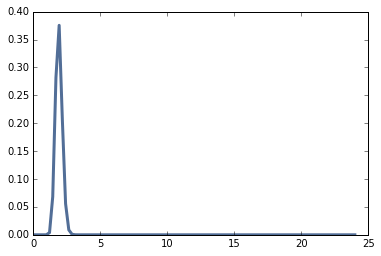

In [118]:
lams = np.linspace(0, 24, 101)
ks = np.linspace(0, 24, 101)
data = [("eq", 5), ("eq", 4), ("eq", 8), ("eq", 6), ("eq", 6), ("eq", 3), ("eq", 6), ("eq", 4), ("eq", 7), 
        ("eq", 6), ("eq", 8), ("eq", 2), ("eq", 1), ("eq", 2), ("eq", 4)]
respirators = Respirator(product(lams, ks))
respirators.UpdateSet(data)
for i in range(85):
    respirators.Update(("gt", 12))
pmf_k = respirators.Marginal(1)
thinkplot.Pdf(pmf_k)
pmf_k.Mean()